In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

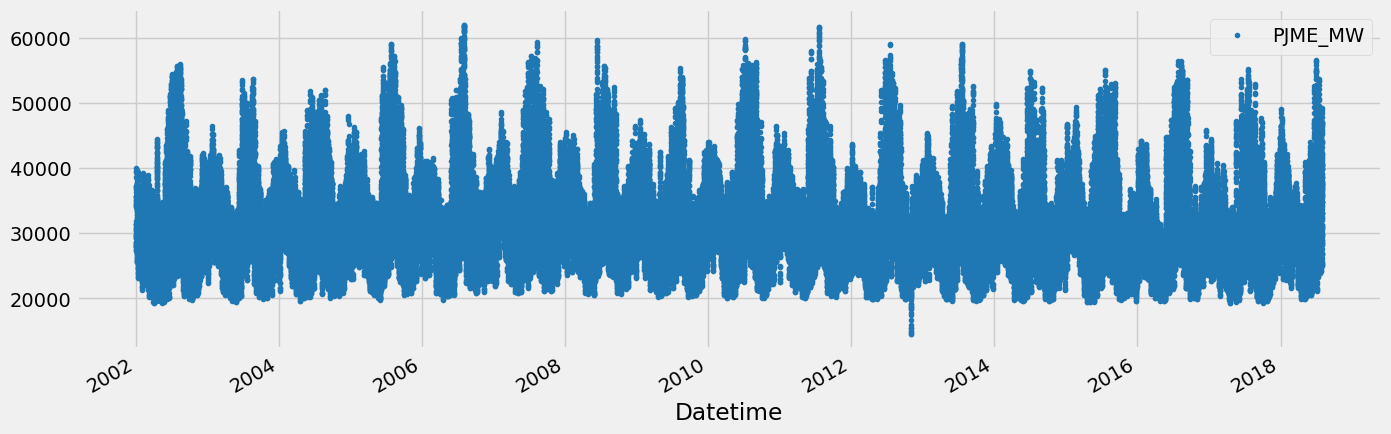

In [3]:
df.plot(style='.', figsize=(15, 5), color=color_pal[0])
plt.show()

## 1. Outlier Analysis and Removal

<Axes: ylabel='Frequency'>

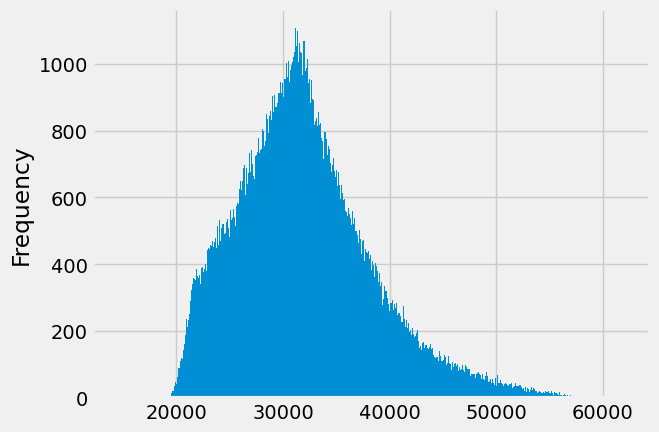

In [4]:
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

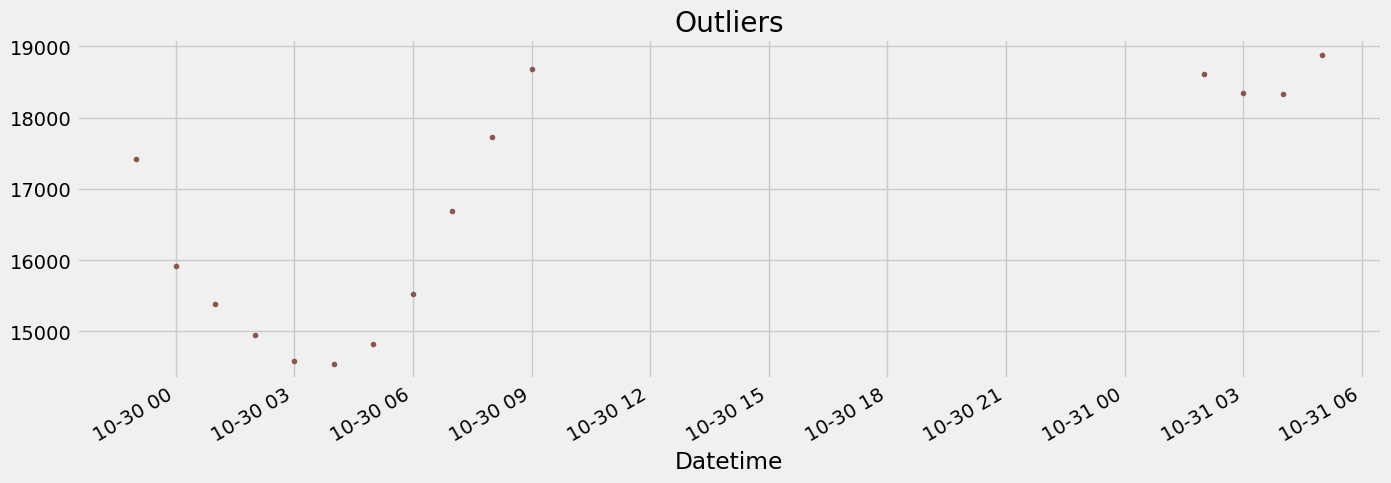

In [5]:
df.query('PJME_MW < 19000')['PJME_MW'] \
    .plot(style='.', 
          figsize=(15, 5), 
          color=color_pal[5], 
          title='Outliers')

In [6]:
df = df.query('PJME_MW > 19000').copy()
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


## Reviewing : Train/Test Split

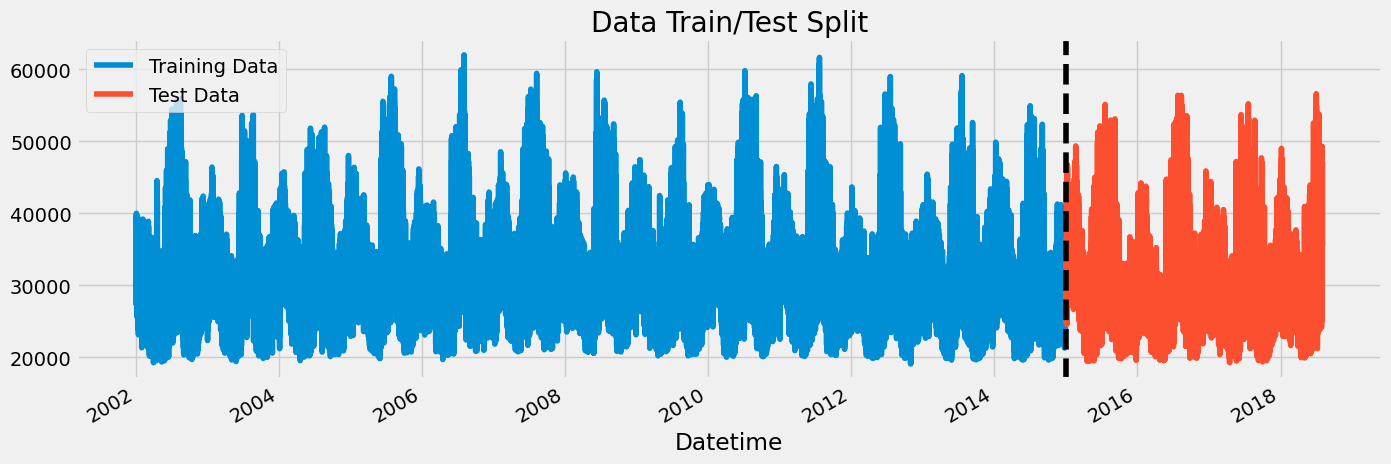

In [7]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Data', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Data')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Data', 'Test Data'])
plt.show()

## 1. Time Series Cross Validation

In [8]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)

df=df.sort_index()

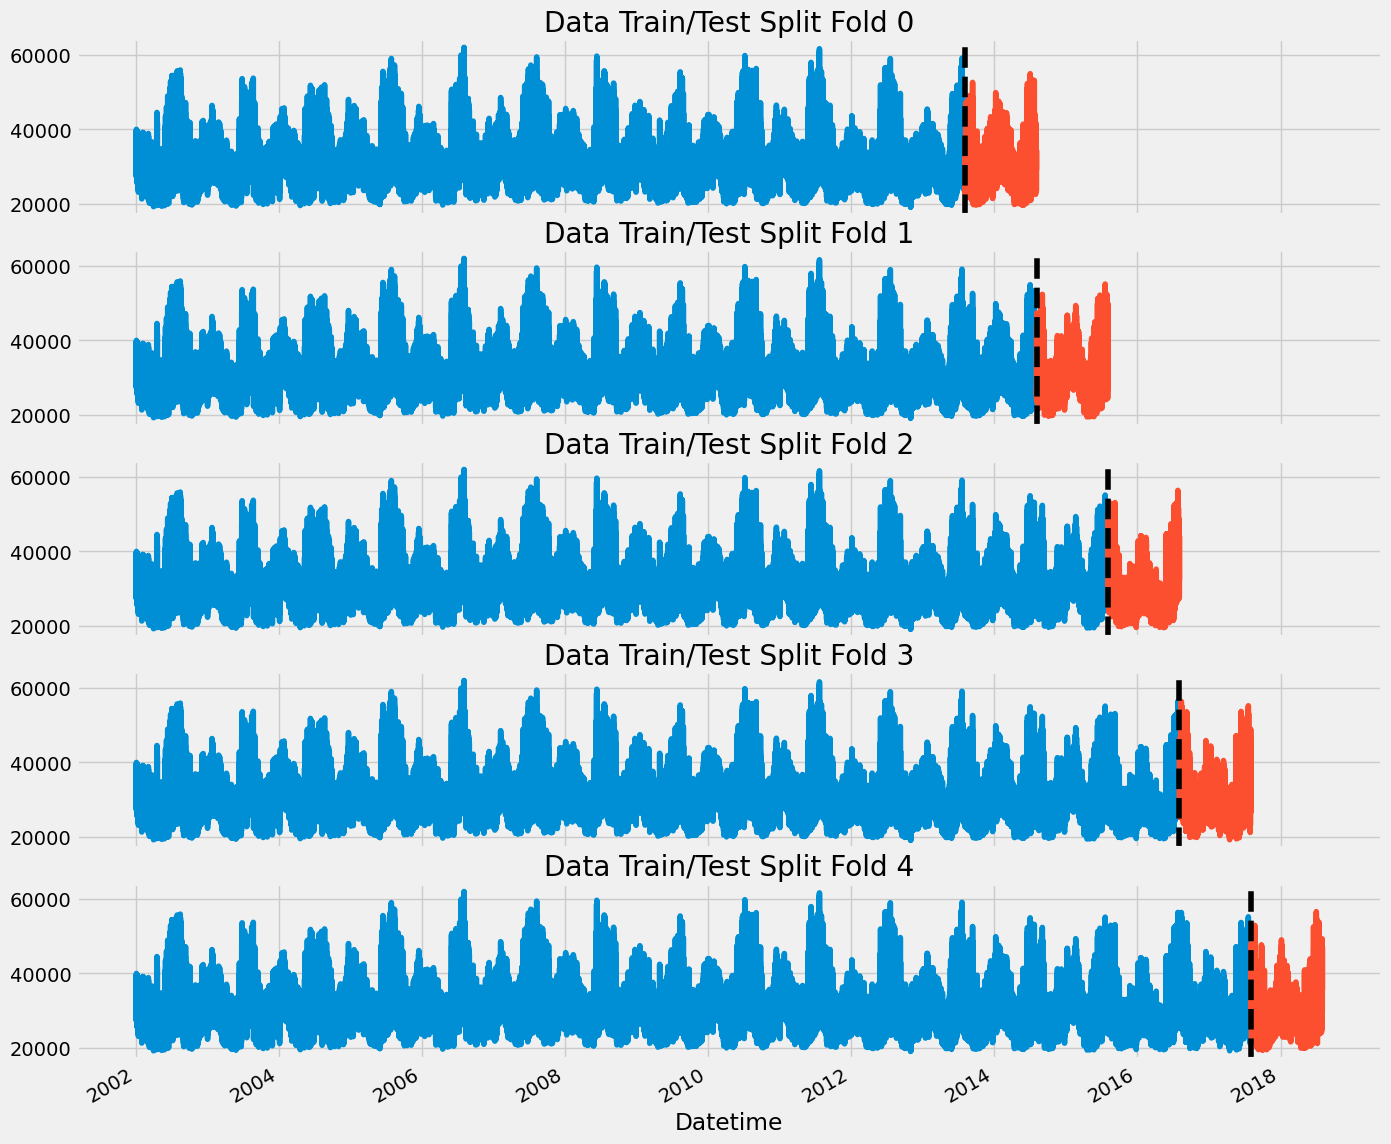

In [9]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold], 
                          label='Training Data', 
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold], 
                         label='Test Data')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()


## 2. Forecasting Horizontal Explained

The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).



In [10]:
def create_features(df):

    df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.day_of_year
    df['dayofmonth'] = df.index.day
    df['week of year'] = df.index.isocalendar().week
    return df

df = create_features(df)


## Lag Features



In [11]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag 1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag 2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag 3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df


In [12]:
df = add_lags(df)

## Train Using Cross Validation

In [13]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx] #iloc is used for integer index
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['hour', 'dayofweek', 'dayofyear', 'month', 'quarter', 'year', 'lag 1', 'lag 2', 'lag 3']
    TARGET = ['PJME_MW']

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), 
                                        (X_test, y_test)], 
                                        verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    

/tmp/ipykernel_20/176498099.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
/tmp/ipykernel_20/176498099.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.day_of_week
/tmp/ipykernel_20/176498099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

[16:22:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.10915	validation_1-rmse:11906.70125
[200]	validation_0-rmse:5739.78666	validation_1-rmse:5352.86754
[300]	validation_0-rmse:3868.29390	validation_1-rmse:3891.32148
[400]	validation_0-rmse:3428.85875	validation_1-rmse:3753.95996
[457]	validation_0-rmse:3348.29869	validation_1-rmse:3761.08467


/tmp/ipykernel_20/176498099.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
/tmp/ipykernel_20/176498099.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.day_of_week
/tmp/ipykernel_20/176498099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

[16:22:57] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.25338	validation_1-rmse:12222.97626
[200]	validation_0-rmse:5755.14393	validation_1-rmse:5649.54800
[300]	validation_0-rmse:3909.18294	validation_1-rmse:3930.98277
[400]	validation_0-rmse:3477.91771	validation_1-rmse:3603.77859
[500]	validation_0-rmse:3356.63775	validation_1-rmse:3534.18452
[600]	validation_0-rmse:3299.24378	validation_1-rmse:3495.69013
[700]	validation_0-rmse:3258.86466	validation_1-rmse:3470.24780
[800]	validation_0-rmse:3222.68998	validation_1-rmse:3446.36557
[900]	validation_0-rmse:3195.04645	validation_1-rmse:3438.00845
[999]	validation_0-rmse:3169.68251	validation_1-rmse:3434.35289


/tmp/ipykernel_20/176498099.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
/tmp/ipykernel_20/176498099.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.day_of_week
/tmp/ipykernel_20/176498099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

[16:23:40] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32631.19070	validation_1-rmse:31073.24659
[100]	validation_0-rmse:12498.56469	validation_1-rmse:11133.47932
[200]	validation_0-rmse:5749.48268	validation_1-rmse:4812.56835
[300]	validation_0-rmse:3915.69493	validation_1-rmse:3552.97165
[400]	validation_0-rmse:3493.17887	validation_1-rmse:3492.55244
[415]	validation_0-rmse:3467.76622	validation_1-rmse:3500.17489


/tmp/ipykernel_20/176498099.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
/tmp/ipykernel_20/176498099.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.day_of_week
/tmp/ipykernel_20/176498099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

[16:23:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32528.44140	validation_1-rmse:31475.37803
[100]	validation_0-rmse:12461.95683	validation_1-rmse:12016.24890
[200]	validation_0-rmse:5736.08201	validation_1-rmse:5800.02075
[300]	validation_0-rmse:3913.36576	validation_1-rmse:4388.02984
[400]	validation_0-rmse:3495.35688	validation_1-rmse:4177.05330
[500]	validation_0-rmse:3380.70922	validation_1-rmse:4123.43863
[600]	validation_0-rmse:3321.42955	validation_1-rmse:4110.84393
[700]	validation_0-rmse:3280.93068	validation_1-rmse:4096.40531
[800]	validation_0-rmse:3249.14336	validation_1-rmse:4095.30547
[808]	validation_0-rmse:3246.39258	validation_1-rmse:4094.57331


/tmp/ipykernel_20/176498099.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
/tmp/ipykernel_20/176498099.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.day_of_week
/tmp/ipykernel_20/176498099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

[16:24:39] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32462.05402	validation_1-rmse:31463.86930


/tmp/ipykernel_20/176498099.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['week of year'] = df.index.isocalendar().week


[100]	validation_0-rmse:12445.22753	validation_1-rmse:11954.79556
[200]	validation_0-rmse:5750.85887	validation_1-rmse:5616.16472
[300]	validation_0-rmse:3949.92308	validation_1-rmse:4154.55799
[400]	validation_0-rmse:3538.33857	validation_1-rmse:3996.70155
[448]	validation_0-rmse:3471.50174	validation_1-rmse:4005.60241


In [14]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores: {scores}')

Score across folds 3750.6406
Fold scores: [3753.2775219986684, 3434.3528874818867, 3475.9138463312997, 4093.3608331481823, 3996.298054855067]


## Predicting the future

In [15]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag 1','lag 2','lag 3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[16:25:02] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.44700
[200]	validation_0-rmse:5752.69704
[300]	validation_0-rmse:3970.08787
[400]	validation_0-rmse:3569.37848
[499]	validation_0-rmse:3454.55122


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [16]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [17]:
# Create future dataframe
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [18]:
df_and_future


,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,week of year,lag 1,lag 2,lag 3,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


In [19]:
future_w_futures = df_and_future.query('isFuture').copy()

In [20]:
future_w_futures

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,week of year,lag 1,lag 2,lag 3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


## Predict the future

In [21]:
future_w_futures['pred'] = reg.predict(future_w_futures[FEATURES])

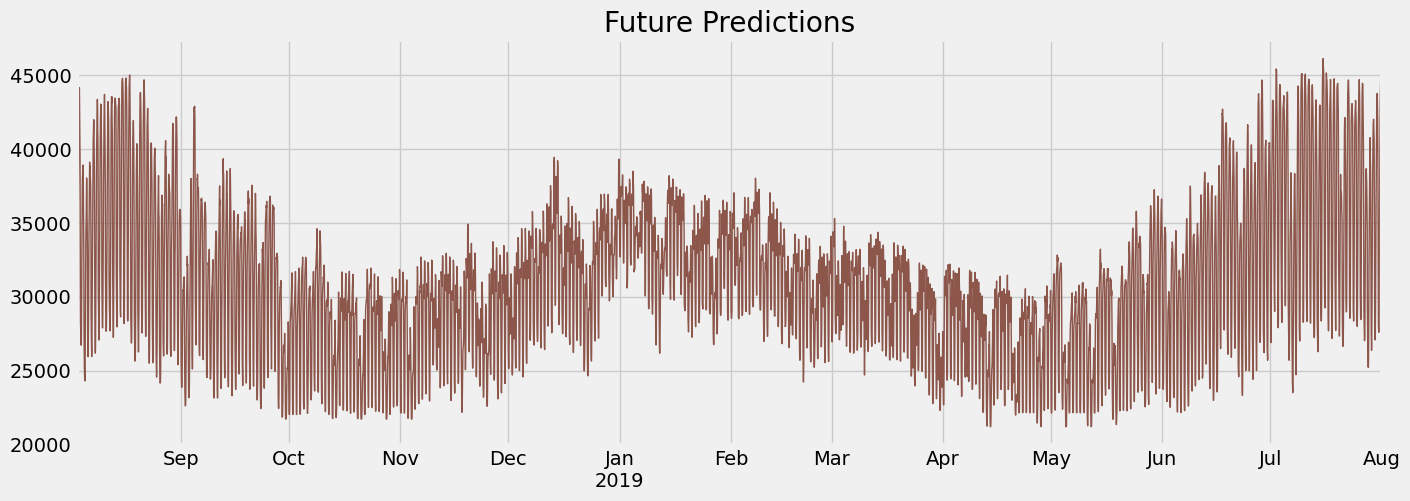

In [22]:
future_w_futures['pred'].plot(figsize=(15, 5), 
                              color=color_pal[5], 
                              ms=1, 
                              lw=1, 
                              title='Future Predictions')
plt.show()

## Bonus: Saving Model for Later

In [23]:
#Save model
reg.save_model('XGBoost model.json')

In [24]:
# !ls -lh in kaggle
# ls -lh in gitbash

total 1.4M

drwxr-xr-x 1 USER 197121    0 Jun  9 14:45 'Hourly Energy Consumption'/

-rw-r--r-- 1 USER 197121 782K Jun  9 23:37 time-series-forecasting-xgboost-part-2.ipynb

-rw-r--r-- 1 USER 197121 572K Jun  9 23:37 'XGBoost model.json'

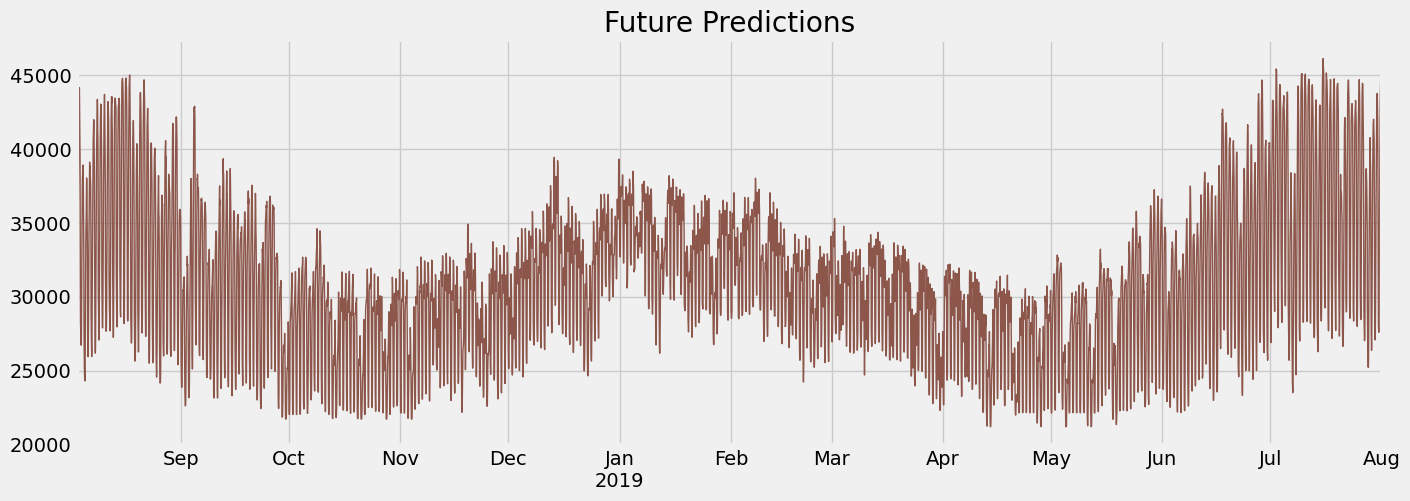

In [25]:
reg_new = xgb.XGBRegressor()
reg_new.load_model("XGBoost model.json")
future_w_futures['pred'] = reg_new.predict(future_w_futures[FEATURES])
future_w_futures['pred'].plot(figsize=(15, 5), 
                              color=color_pal[5], 
                              ms=1, lw=1, 
                              title='Future Predictions')
plt.show()